In [37]:
# loading packages for JSONstat and data handling
#install.packages('rjstat')
#install.packages('reshape2')
#install.packages('zoo')

library(rjstat)
library(tidyr)
library(tidyverse)
library(ggplot2)
library(reshape2)
library(zoo)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘gdtools’


Warning message in install.packages("hrbrthemes"):
“installation of package ‘gdtools’ had non-zero exit status”
Warning message in install.packages("hrbrthemes"):
“installation of package ‘hrbrthemes’ had non-zero exit status”


ERROR: ignored

In [9]:
# URL base
url_base <- "https://sampo.thl.fi/pivot/prod/fi/epirapo/covid19case/fact_epirapo_covid19case.json"

# request endpoint
request <- "?row=hcdmunicipality2020-445222&column=dateweek20200101-508804L&filter=measure-444833"

# concatenating url
url <- paste0(url_base, request)

# fetching the data from API
cube <- fromJSONstat(url, naming = "label", use_factors = F, silent = T)

# data from the cube to its own object
res <- cube[[1]]

# renaming the data columns
names(res)[names(res) == 'dateweek20200101'] <- 'Date'
names(res)[names(res) == 'hcdmunicipality2020'] <- 'Municipality'
names(res)[names(res) == 'value'] = 'Cases'

# reformatting data
class(res$Cases) = "double"
res[['Date']] = as.Date(res[['Date']])

# replacing na with zeros 
res[is.na(res)] = 0

# pivoting municipality-column values to new columns
res_fin = res %>% pivot_wider(
  names_from = Municipality, 
  values_from = Cases,
  values_fill = 0
)

Date,Ahvenanmaa,Varsinais-Suomen SHP,Satakunnan SHP,Kanta-Hämeen SHP,Pirkanmaan SHP,Päijät-Hämeen SHP,Kymenlaakson SHP,Etelä-Karjalan SHP,Etelä-Savon SHP,⋯,Keski-Suomen SHP,Etelä-Pohjanmaan SHP,Vaasan SHP,Keski-Pohjanmaan SHP,Pohjois-Pohjanmaan SHP,Kainuun SHP,Länsi-Pohjan SHP,Lapin SHP,Helsingin ja Uudenmaan SHP,Kaikki Alueet
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-01-01,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2020-01-02,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2020-01-03,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2020-01-04,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2020-01-05,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2020-01-06,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2020-01-07,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2020-01-08,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2020-01-09,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



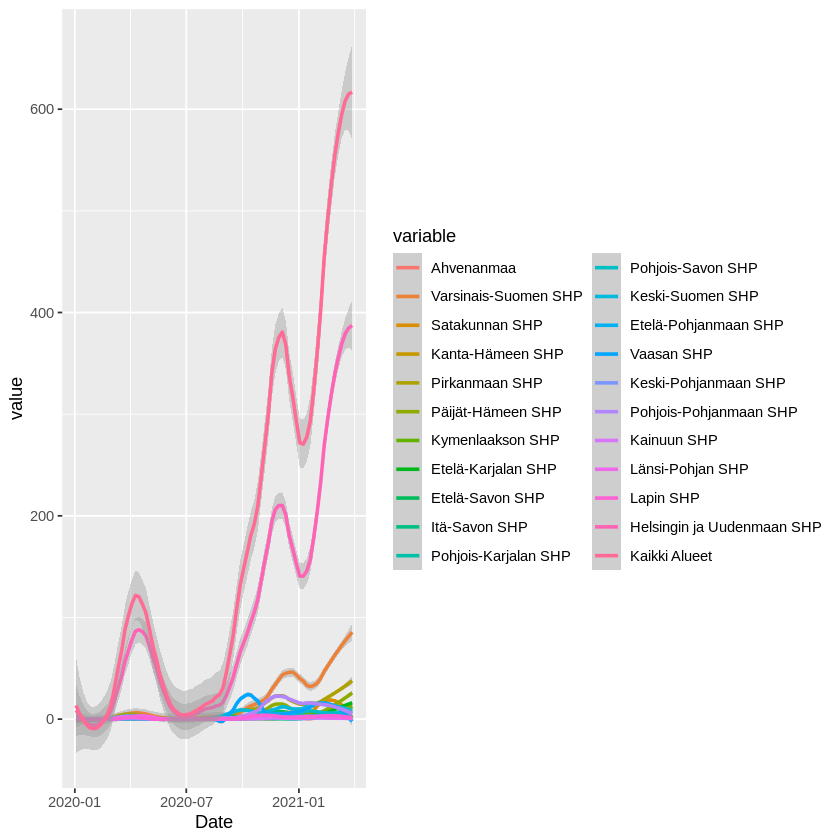

In [58]:
#plotting data

filtered_data = res_fin %>%
  #select('Date', 'Pirkanmaan SHP', 'Helsingin ja Uudenmaan SHP', ) %>%
  filter(Date >= as.Date("2020-01-03") & Date <= as.Date('2021-03-29'))

d = melt(filtered_data, id.vars='Date')

# Everything on the same plot
ggplot(d, aes(Date,value, col=variable)) +  
  stat_smooth(span = 0.25) 


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



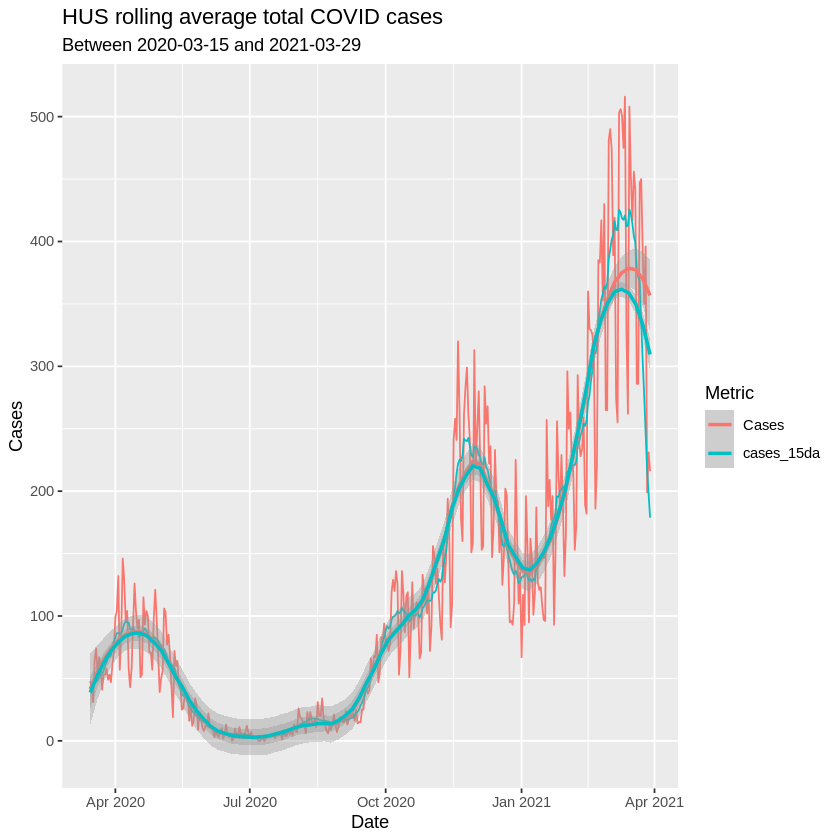

In [50]:
# calculating moving averages
data_moving_averages = res %>%
    dplyr::arrange(desc(Municipality)) %>% 
    dplyr::group_by(Municipality) %>% 
    dplyr::mutate(cases_03da = zoo::rollmean(Cases, k = 3, fill = NA),
                  cases_05da = zoo::rollmean(Cases, k = 5, fill = NA),
                  cases_07da = zoo::rollmean(Cases, k = 7, fill = NA),
                  cases_15da = zoo::rollmean(Cases, k = 15, fill = NA),
                  cases_21da = zoo::rollmean(Cases, k = 21, fill = NA)) %>% 
  dplyr::ungroup()

data_moving_averages %>% 
  dplyr::filter(Municipality == 'Helsingin ja Uudenmaan SHP') %>% 
  tidyr::pivot_longer(names_to = "rolling_mean_key", 
                    values_to = "rolling_mean_value", 
                    cols = c(Cases, 
                             cases_15da)) %>%
  dplyr::filter(Date >= lubridate::as_date("2020-03-15") &
                  Date <= lubridate::as_date("2021-03-29")) %>% 
  ggplot2::ggplot(aes(x = Date, 
                      y = rolling_mean_value, 
                      color = rolling_mean_key)) +
  ggplot2::geom_line() +   
  ggplot2::labs(title = "HUS rolling average total COVID cases", 
                  subtitle = "Between 2020-03-15 and 2021-03-29",
                  y = "Cases", 
                  color = "Metric",
                  x = "Date") +
  ggplot2::geom_smooth(aes(x = Date, y = rolling_mean_value, color = rolling_mean_key), span = 0.25)


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



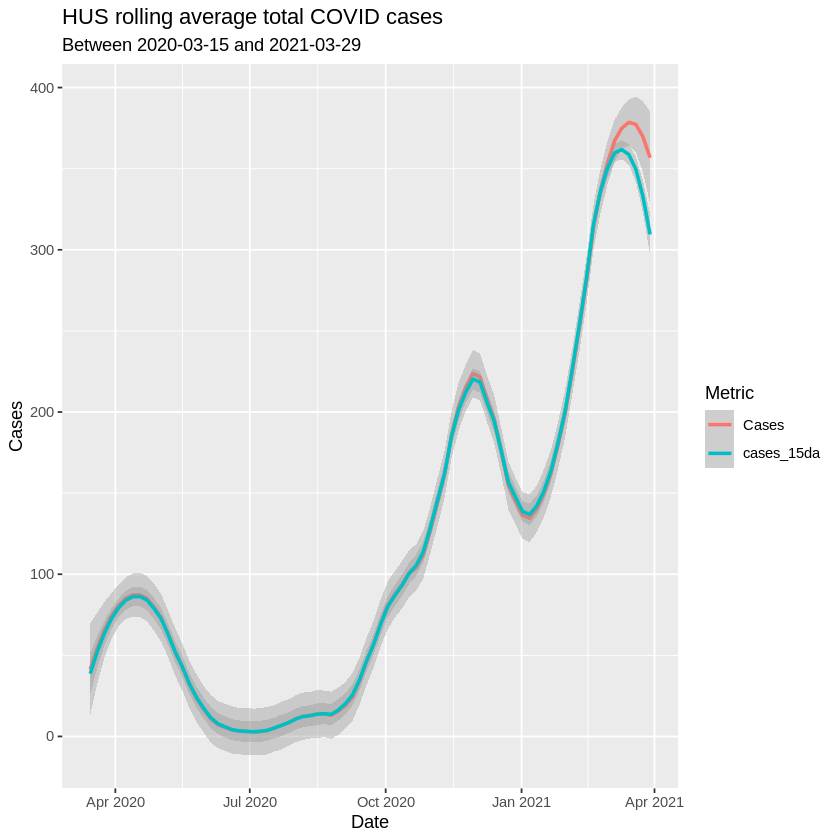

In [57]:
data_moving_averages %>% 
  dplyr::filter(Municipality == 'Helsingin ja Uudenmaan SHP') %>% 
  tidyr::pivot_longer(names_to = "rolling_mean_key", 
                    values_to = "rolling_mean_value", 
                    cols = c(Cases, 
                             cases_15da)) %>%
  dplyr::filter(Date >= lubridate::as_date("2020-03-15") &
                  Date <= lubridate::as_date("2021-03-29")) %>% 
  ggplot2::ggplot(aes(x = Date, 
                      y = rolling_mean_value, 
                      color = rolling_mean_key)) +
  ggplot2::geom_smooth(span = .25) +   
  ggplot2::labs(title = "HUS smoothed rolling average total COVID cases", 
                  subtitle = "Between 2020-03-15 and 2021-03-29",
                  y = "Cases", 
                  color = "Metric",
                  x = "Date")